# Librerías Necesarias

In [1]:
# Importamos las librerías requeridas para el proyecto
import streamlit as st
import pandas as pd
import numpy as np
import ast
import chess
import chess.pgn
import io
import requests
import os
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm.notebook import tqdm
from pathlib import Path
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.exceptions import NotFittedError

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model, utils, callbacks

import shap
import warnings
import joblib

# Import Stockfish
import stockfish


from utils import pgn_to_dataframe, extraer_time_control
from evaluador import Evaluador
from Ajedrez_Prediccion import ChessResultPredictor

warnings.filterwarnings('ignore')

# Datasets

## Carga de Datos

In [2]:
# Usamos la funcion pgn_to_dataframe para convertir el contenido PGN a un DataFrame
pgn_content = open('../Data/Raw/lichess_db_standard_rated_2013-01.pgn', 'r').read()

Games = pgn_to_dataframe(pgn_content)
Games.info()

Archivo guardado exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121332 entries, 0 to 121331
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Event        121332 non-null  object
 1   Result       121332 non-null  int64 
 2   WhiteElo     121332 non-null  int64 
 3   BlackElo     121332 non-null  int64 
 4   TimeControl  121332 non-null  object
 5   ECO          121332 non-null  object
 6   Opening      121332 non-null  object
 7   Moves        121332 non-null  object
dtypes: int64(3), object(5)
memory usage: 7.4+ MB


## EDA

In [3]:
# Mostramos los primeros registros
Games.head()

,Event,Result,WhiteElo,BlackElo,TimeControl,ECO,Opening,Moves
0,Rated Classical game,0,1639,1403,600+8,C00,French Defense: Normal Variation,e4 e6 d4 b6 a3 Bb7 Nc3 Nh6 Bxh6 gxh6 Be2 Qg5 B...
1,Rated Classical game,0,1654,1919,480+2,D04,"Queen's Pawn Game: Colle System, Anti-Colle",d4 d5 Nf3 Nf6 e3 Bf5 Nh4 Bg6 Nxg6 hxg6 Nd2 e6 ...
2,Rated Classical game,0,1643,1747,420+17,C50,Four Knights Game: Italian Variation,e4 e5 Nf3 Nc6 Bc4 Nf6 Nc3 Bc5 a3 Bxf2+ Kxf2 Nd...
3,Rated Bullet game,1,1824,1973,60+1,B12,Caro-Kann Defense: Goldman Variation,e4 c6 Nc3 d5 Qf3 dxe4 Nxe4 Nd7 Bc4 Ngf6 Nxf6+ ...
4,Rated Bullet game,1,1765,1815,60+1,C00,French Defense: La Bourdonnais Variation,e4 e6 f4 d5 e5 c5 Nf3 Qb6 c3 Nc6 d3 Bd7 Be2 Nh...


In [4]:
# Reemplazamos valores de cadena vacía obtenidos con NaN
Games.replace(["",'Unknown', '?'], np.nan, inplace=True)

<Axes: >

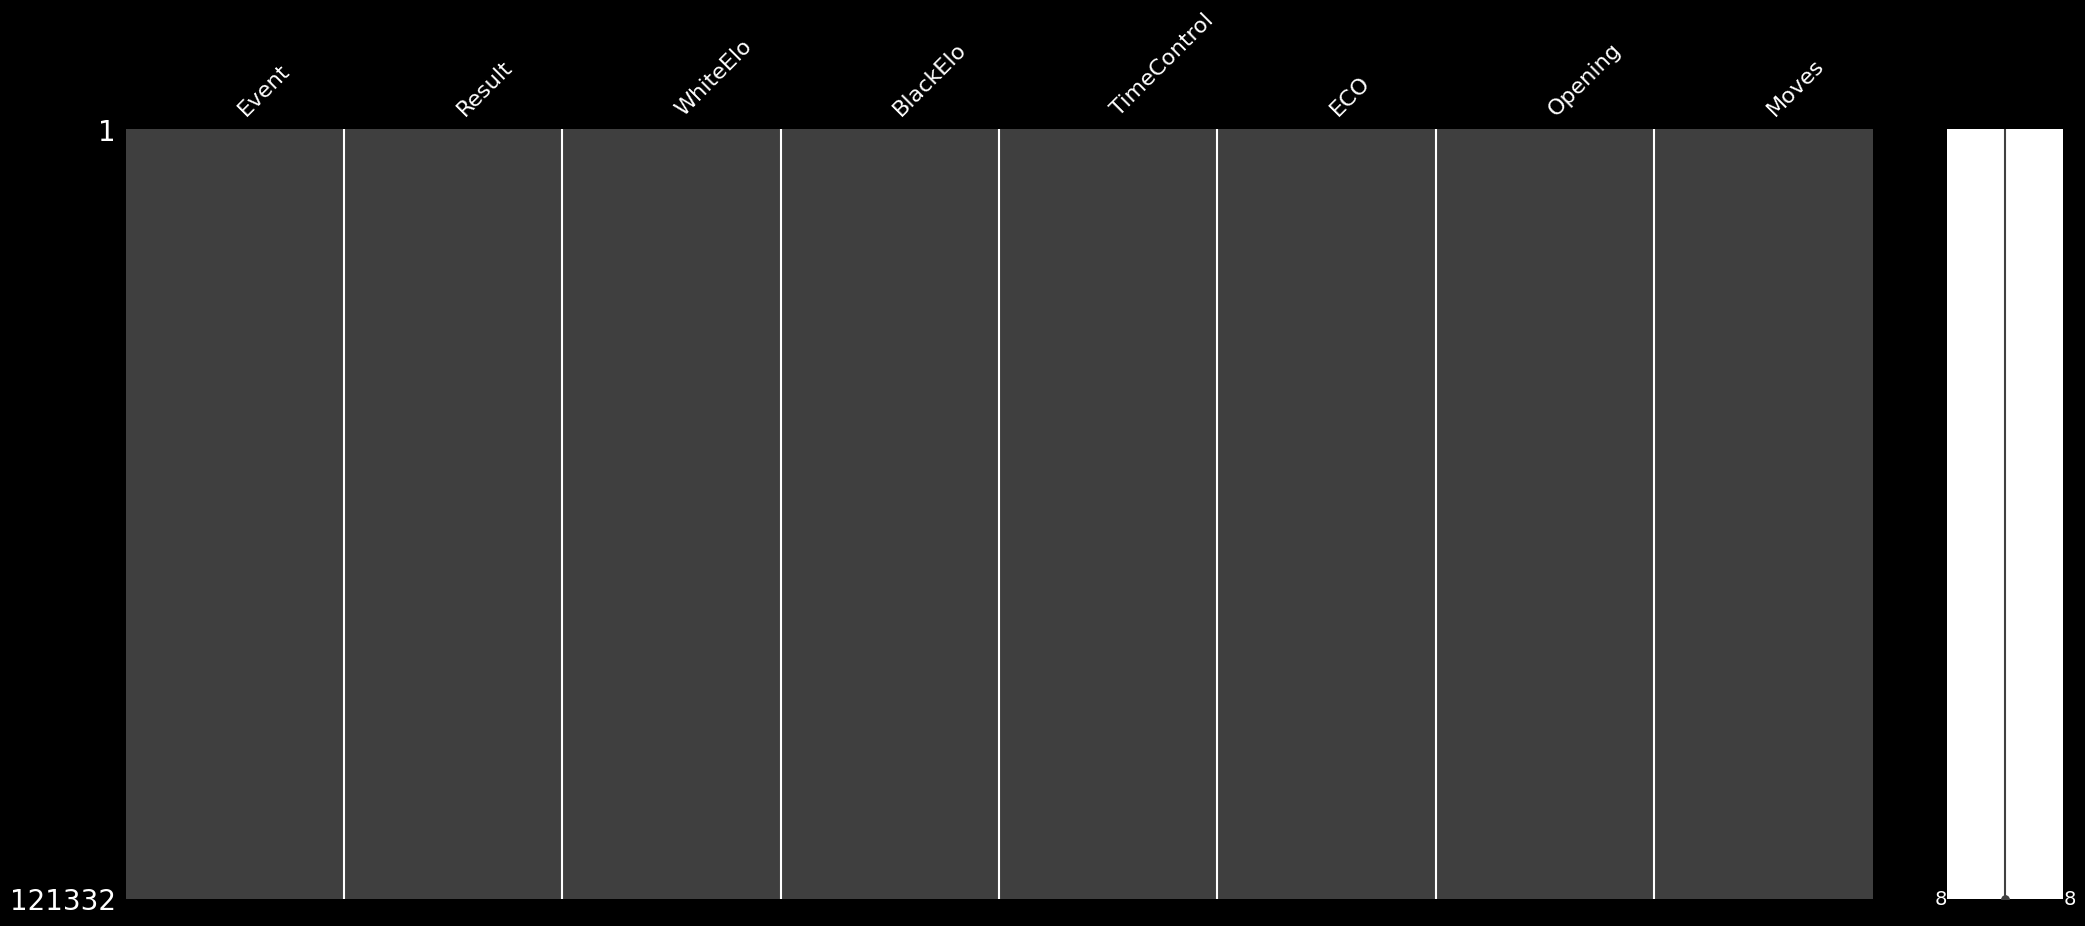

In [5]:
# Mostramos los valores nulos
Games.isnull().sum()

#Usamos missingno para visualizar los valores nulos
msno.matrix(Games)

In [6]:
# Mostramos los valores únicos de las columnas
Games.nunique().sort_values()

Result              3
Event             151
TimeControl       396
ECO               411
WhiteElo         1346
BlackElo         1358
Opening          1846
Moves          120521
dtype: int64

In [7]:
# Mostramos de forma descendente la cantidad de eventos
Games['Event'].value_counts(sort=True, ascending=False)

Event
Rated Blitz game                                                      45388
Rated Classical game                                                  41772
Rated Bullet game                                                     32691
Rated Correspondence game                                               266
Rated Blitz tournament https://lichess.org/tournament/eaxo4pkh           18
                                                                      ...  
Rated Classical tournament https://lichess.org/tournament/dshcjgey        2
Rated Blitz tournament https://lichess.org/tournament/dbu4m3u3            2
Rated Blitz tournament https://lichess.org/tournament/uitsh1pw            2
Rated Blitz tournament https://lichess.org/tournament/lpotikyv            1
Rated Bullet tournament https://lichess.org/tournament/k4se9ydi           1
Name: count, Length: 151, dtype: int64

In [8]:
# Filtramos los eventos que tengan más de 20 juegos
events_20 = Games['Event'].value_counts()[Games['Event'].value_counts() > 20].index

# Filter the Games DataFrame
Games = Games[Games['Event'].isin(events_20)]
Games.shape

(120117, 8)

In [9]:
# Convertimos TimeControl a segundos base
Games['TimeControl'] = Games['TimeControl'].apply(extraer_time_control)

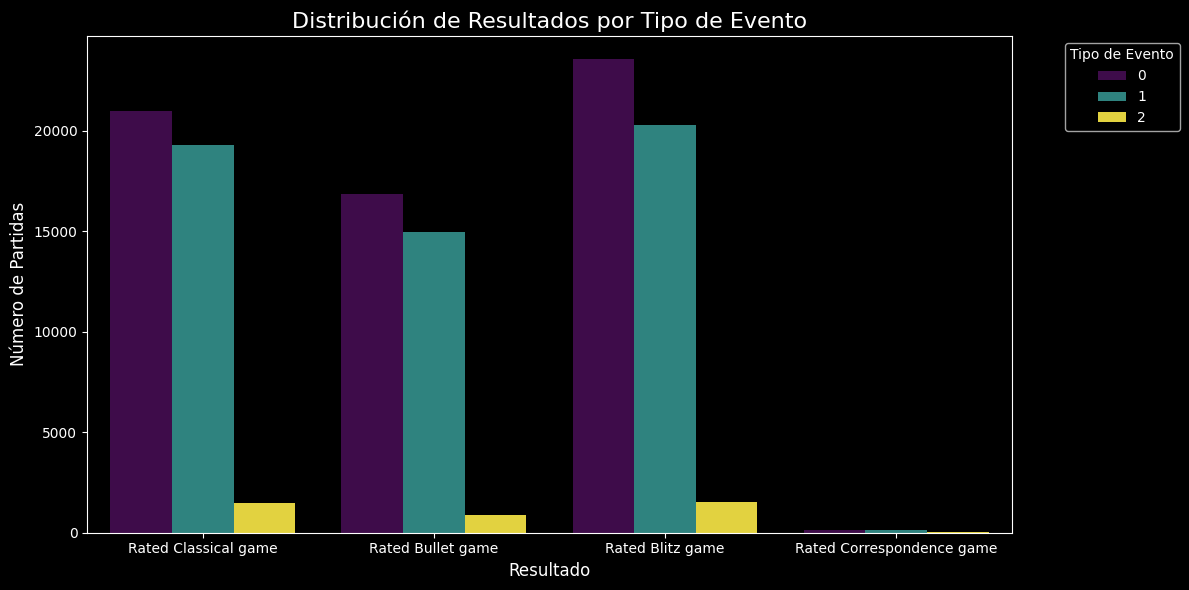

In [10]:
# Visualizamos los resultados con el tipo de eventos

plt.figure(figsize=(12, 6))
sns.countplot(
    x='Event',  
    hue= 'Result',
    data=Games,  
    palette='viridis')

# Personalizamos el gráfico
plt.title('Distribución de Resultados por Tipo de Evento', fontsize=16)
plt.xlabel('Resultado', fontsize=12)
plt.ylabel('Número de Partidas', fontsize=12)
plt.legend(title='Tipo de Evento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostramos el gráfico
plt.show()

In [11]:
# Seleccionamos las columnas categóricas
columnas_categoricas = ['Event', 'ECO', 'Opening']

# Aplicamos pd.factorize() a cada columna categórica
for columna in columnas_categoricas:
    Games[columna], _ = pd.factorize(Games[columna])

In [12]:
# Verificamos las estadísticas de los datos
Games.describe()

,Event,Result,WhiteElo,BlackElo,TimeControl,ECO,Opening
count,120117.000000,120117.000000,120117.000000,120117.000000,120117.000000,120117.000000,120117.000000
mean,1.034533,0.520526,1605.030828,1594.221293,304.333292,44.701533,245.241090
std,0.856328,0.561249,207.059390,214.779241,289.965866,50.897079,287.370777
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1474.000000,1462.000000,120.000000,12.000000,53.000000
50%,1.000000,0.000000,1602.000000,1588.000000,300.000000,27.000000,147.000000
75%,2.000000,1.000000,1739.000000,1732.000000,363.000000,57.000000,326.000000
max,3.000000,2.000000,2403.000000,2386.000000,1830.000000,410.000000,1843.000000


# Modelo

In [13]:
# Crear instancia del predictor
predictor = ChessResultPredictor(models_dir='../models/mi_modelo_ajedrez')

# Entrenar modelos
eval_results = predictor.train_models(
    df=Games, 
    moves_col='Moves',  # Columna con los movimientos
    result_col='Result',  # Columna con los resultados
    batch_size=10000
)

Preparando datos para entrenamiento...
Extrayendo características usando el evaluador...


Procesando lotes: 100%|██████████| 121/121 [01:03<00:00,  1.89it/s]


Preparando datos para entrenamiento...
Usando características ya extraídas del DataFrame
Datos preparados: 120117 muestras, 45 características
Entrenando modelo de predicción de resultado...
Escalando características...
Realizando búsqueda de hiperparámetros (esto puede tomar tiempo)...
Usando una muestra de 50000 ejemplos para búsqueda de hiperparámetros
Mejores hiperparámetros: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Entrenando en lotes de 10000 ejemplos...
[0]	validation_0-mlogloss:0.97416
[1]	validation_0-mlogloss:0.88224
[2]	validation_0-mlogloss:0.81616
[3]	validation_0-mlogloss:0.76091
[4]	validation_0-mlogloss:0.71719
[5]	validation_0-mlogloss:0.68100
[6]	validation_0-mlogloss:0.65046
[7]	validation_0-mlogloss:0.62546
[8]	validation_0-mlogloss:0.60527
[9]	validation_0-mlogloss:0.58692
[10]	validation_0-mlogloss:0.57237
[11]	validation_0-mlogloss:0.56060
[12]	validation_0-mlogloss:0.54952
[13]	

Entrenando lotes: 100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


Precisión del modelo: 0.7820
F1-score: 0.7793
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     12305
           1       0.78      0.78      0.78     10933
           2       0.41      0.27      0.32       786

    accuracy                           0.78     24024
   macro avg       0.66      0.62      0.64     24024
weighted avg       0.78      0.78      0.78     24024

Realizando validación cruzada con una muestra de 50000 ejemplos...
F1-score en validación cruzada: 0.8098 ± 0.0023
Entrenando modelo de predicción de rendimiento...
Entrenando modelo para rendimiento de blancas...
Realizando búsqueda de hiperparámetros para white...
Usando una muestra de 50000 ejemplos para búsqueda de hiperparámetros
Mejores hiperparámetros para white: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Entrenando en lotes de 10000 ejemplos...


Entrenando lotes para white: 100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


MSE para white: 61.4446
R² para white: 0.5941
Entrenando modelo para rendimiento de negras...
Realizando búsqueda de hiperparámetros para black...
Usando una muestra de 50000 ejemplos para búsqueda de hiperparámetros
Mejores hiperparámetros para black: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Entrenando en lotes de 10000 ejemplos...


Entrenando lotes para black: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


MSE para black: 51.3111
R² para black: 0.6254
Entrenando red neuronal para rendimiento...
Usando 10000 ejemplos para validación
Entrenando red neuronal en lotes de 10000 ejemplos...
Época 1/50


Lotes: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


loss: 443.4577 - mae: 14.1362 - val_loss: 52.0373 - val_mae: 5.6329
Guardando mejor modelo...
Época 2/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


loss: 58.0044 - mae: 5.9079 - val_loss: 50.9917 - val_mae: 5.3853
Guardando mejor modelo...
Época 3/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


loss: 56.4655 - mae: 5.7491 - val_loss: 49.8883 - val_mae: 5.3007
Guardando mejor modelo...
Época 4/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


loss: 55.6185 - mae: 5.6720 - val_loss: 49.9933 - val_mae: 5.2127
Época 5/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


loss: 55.0635 - mae: 5.6138 - val_loss: 47.7260 - val_mae: 5.0251
Guardando mejor modelo...
Época 6/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


loss: 54.3430 - mae: 5.5566 - val_loss: 48.1168 - val_mae: 5.0393
Época 7/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


loss: 54.1894 - mae: 5.5318 - val_loss: 48.1843 - val_mae: 5.1279
Época 8/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


loss: 53.9090 - mae: 5.5130 - val_loss: 47.4677 - val_mae: 5.1509
Guardando mejor modelo...
Época 9/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


loss: 53.7986 - mae: 5.5085 - val_loss: 47.5316 - val_mae: 5.1472
Época 10/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


loss: 53.2223 - mae: 5.4573 - val_loss: 47.4457 - val_mae: 5.1361
Guardando mejor modelo...
Época 11/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


loss: 53.2010 - mae: 5.4577 - val_loss: 47.8145 - val_mae: 5.0816
Época 12/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


loss: 52.9397 - mae: 5.4330 - val_loss: 47.1010 - val_mae: 4.9704
Guardando mejor modelo...
Época 13/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


loss: 52.6973 - mae: 5.4151 - val_loss: 46.8081 - val_mae: 4.9810
Guardando mejor modelo...
Época 14/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


loss: 52.6855 - mae: 5.4052 - val_loss: 47.2120 - val_mae: 5.0482
Época 15/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


loss: 52.5623 - mae: 5.3842 - val_loss: 47.3613 - val_mae: 4.9510
Época 16/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


loss: 52.1692 - mae: 5.3535 - val_loss: 47.0173 - val_mae: 4.9103
Época 17/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


loss: 51.9204 - mae: 5.3415 - val_loss: 46.7550 - val_mae: 4.9263
Guardando mejor modelo...
Época 18/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


loss: 52.1979 - mae: 5.3461 - val_loss: 46.6702 - val_mae: 4.9284
Guardando mejor modelo...
Época 19/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


loss: 51.7865 - mae: 5.3259 - val_loss: 46.6325 - val_mae: 4.9755
Guardando mejor modelo...
Época 20/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


loss: 51.9316 - mae: 5.3414 - val_loss: 46.7328 - val_mae: 4.9572
Época 21/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


loss: 51.6280 - mae: 5.3171 - val_loss: 46.5557 - val_mae: 5.0451
Guardando mejor modelo...
Época 22/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


loss: 51.7581 - mae: 5.3192 - val_loss: 46.2662 - val_mae: 4.8354
Guardando mejor modelo...
Época 23/50


Lotes: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


loss: 51.5055 - mae: 5.2977 - val_loss: 46.2824 - val_mae: 4.8672
Early stopping en época 23
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step
Error cuadrático medio: 46.5938
Error absoluto medio: 4.8622
R² Score: 0.6867
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
Usando una muestra de 1000 ejemplos para comparación de modelos
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Comparación de modelos de rendimiento:
XGBoost - Rendimiento Blancas MSE: 63.0011
Red Neuronal - Rendimiento Blancas MSE: 50.3761
XGBoost - Rendimiento Negras MSE: 53.9491
Red Neuronal - Rendimiento Negras MSE: 45.9645
